In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
# pip install dash
from dash import Dash, dcc, html, Input, Output
from dash.dependencies import Input, Output


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the datasets
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')

In [4]:
def handle_missing_values(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column].fillna('Unknown', inplace=True)
        elif df[column].dtype in ['int64', 'float64']:
            df[column].fillna(df[column].median(), inplace=True)
    return df

def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    return df


In [5]:
customers = handle_missing_values(customers)
order_items = handle_missing_values(order_items)
products = handle_missing_values(products)

date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

for col in date_columns:
    
    orders[col] = pd.to_datetime(orders[col], errors='coerce')


placeholder_date = orders[date_columns].min().min()
orders[date_columns] = orders[date_columns].fillna(placeholder_date)

In [6]:
order_items = handle_outliers(order_items, 'price')
order_items = handle_outliers(order_items, 'freight_value')

In [7]:
merged_data = orders.merge(order_items, on='order_id')
merged_data = merged_data.merge(products, on='product_id')
merged_data = merged_data.merge(customers, on='customer_id')


merged_data['total_price'] = merged_data['price'] + merged_data['freight_value']
merged_data['order_year_month'] = merged_data['order_purchase_timestamp'].dt.to_period('M')
merged_data['delivery_time'] = (merged_data['order_delivered_customer_date'] - merged_data['order_purchase_timestamp']).dt.total_seconds() / 86400

merged_data.drop_duplicates(inplace=True)


merged_data.to_csv('cleaned_ecommerce_data.csv', index=False)
print("Data cleaning completed. Cleaned data saved as 'cleaned_ecommerce_data.csv'")

Data cleaning completed. Cleaned data saved as 'cleaned_ecommerce_data.csv'


In [8]:
print("\nSummary Statistics:")
print(merged_data.describe())

print("\nRemaining missing values:")
print(merged_data.isnull().sum())

print("\nCleaned Dataset Info:")
print(merged_data.info())


Summary Statistics:
            order_purchase_timestamp              order_approved_at  \
count                         112650                         112650   
mean   2018-01-01 00:09:48.464376320  2018-01-01 10:13:17.789613824   
min              2016-09-04 21:15:19            2016-09-04 21:15:19   
25%              2017-09-13 19:17:04  2017-09-14 02:57:55.249999872   
50%              2018-01-19 23:02:16            2018-01-20 12:50:58   
75%    2018-05-04 17:30:36.750000128     2018-05-05 03:06:27.500000   
max              2018-09-03 09:06:57            2018-09-03 17:40:06   
std                              NaN                            NaN   

        order_delivered_carrier_date  order_delivered_customer_date  \
count                         112650                         112650   
mean   2017-12-30 22:26:40.067092736  2018-01-03 17:45:03.493723904   
min              2016-09-04 21:15:19            2016-09-04 21:15:19   
25%    2017-09-12 23:40:34.249999872  2017-09-15 12:54:

In [9]:

df = pd.read_csv('cleaned_ecommerce_data.csv')

In [11]:
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col])


# plt.style.use('seaborn')
sns.set_palette("deep")

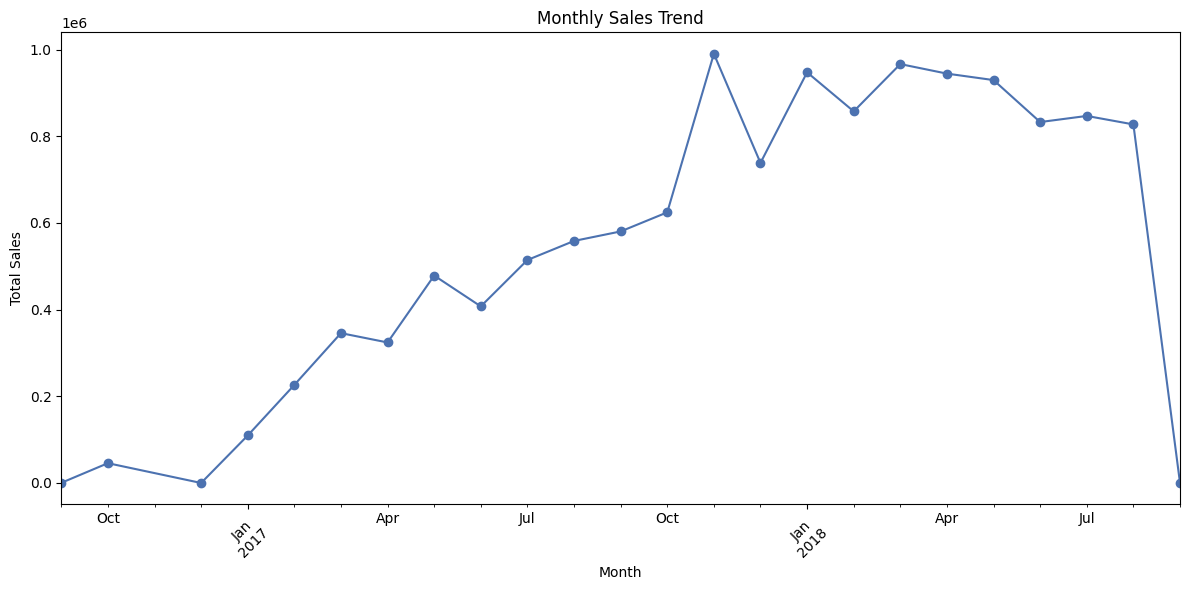

In [12]:
plt.figure(figsize=(12, 6))
monthly_sales = df.groupby(df['order_purchase_timestamp'].dt.to_period('M'))['total_price'].sum()
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('monthly_sales_trend.png')
plt.close()


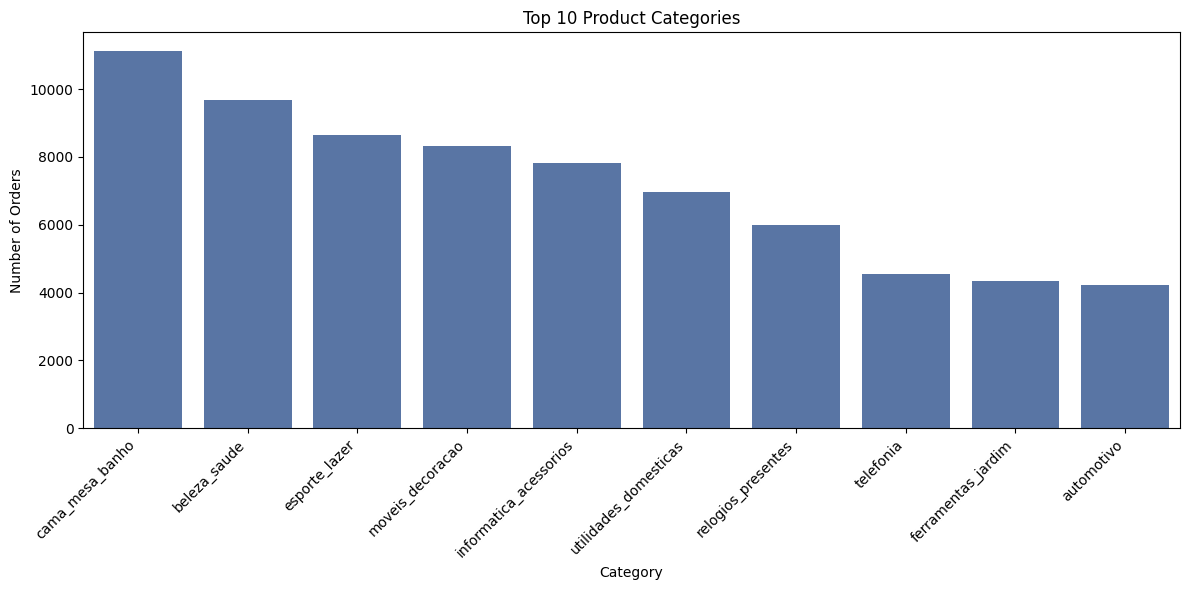

In [13]:
plt.figure(figsize=(12, 6))
top_categories = df['product_category_name'].value_counts().head(10)
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.title('Top 10 Product Categories')
plt.xlabel('Category')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig('top_product_categories.png')
plt.close()


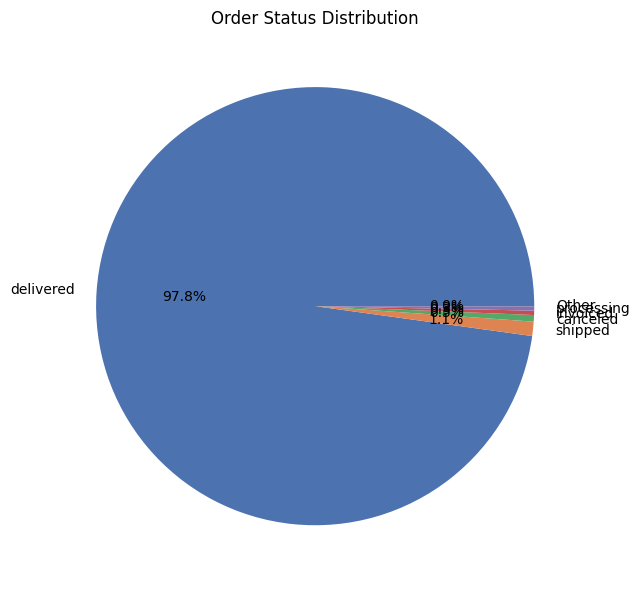

In [14]:
plt.figure(figsize=(10, 6))
order_status = df['order_status'].value_counts()

if len(order_status) > 5:
    other = pd.Series({'Other': order_status[5:].sum()})
    order_status = pd.concat([order_status[:5], other])
order_status.plot(kind='pie', autopct='%1.1f%%')
plt.title('Order Status Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()
plt.savefig('order_status_distribution.png')
plt.close()

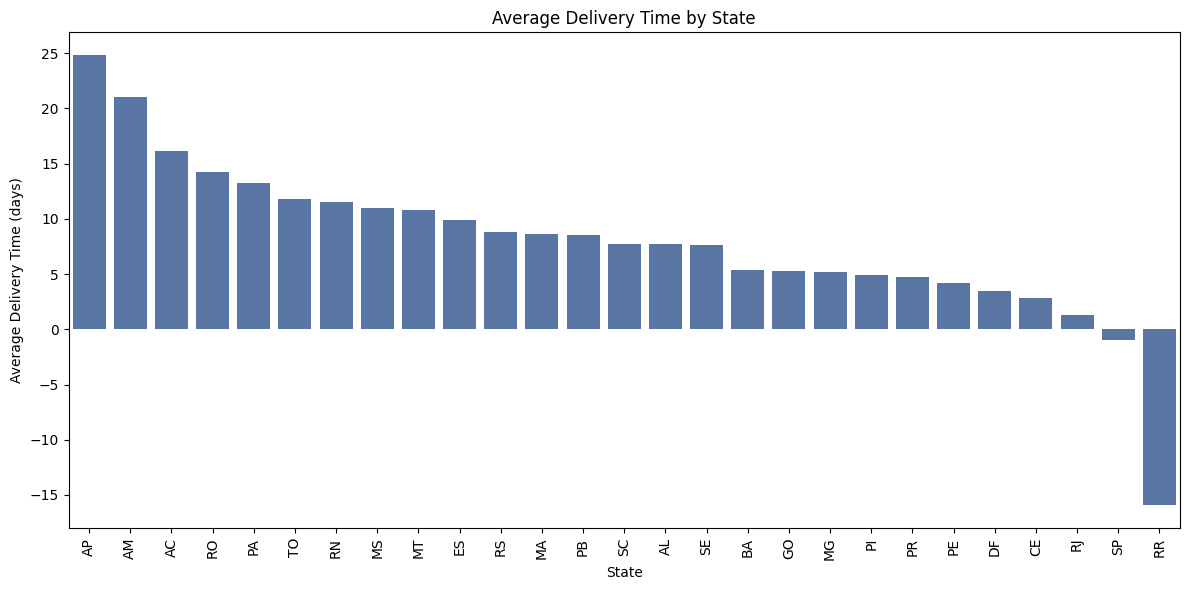

In [15]:
plt.figure(figsize=(12, 6))
avg_delivery_time = df.groupby('customer_state')['delivery_time'].mean().sort_values(ascending=False)
sns.barplot(x=avg_delivery_time.index, y=avg_delivery_time.values)
plt.title('Average Delivery Time by State')
plt.xlabel('State')
plt.ylabel('Average Delivery Time (days)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.savefig('avg_delivery_time_by_state.png')
plt.close()

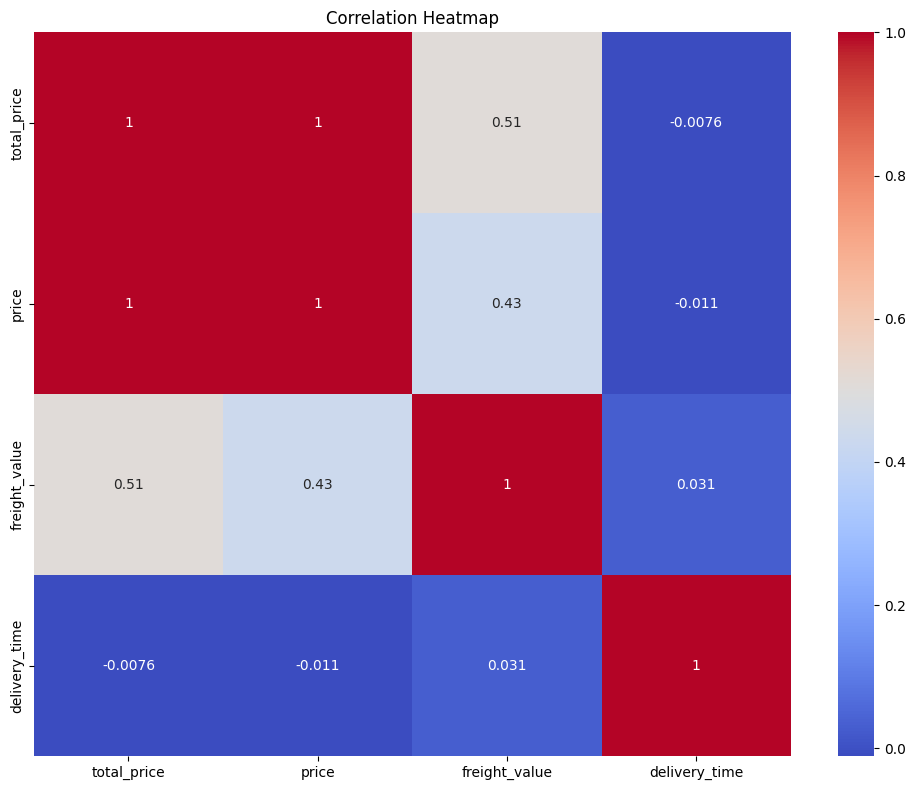

In [16]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[['total_price', 'price', 'freight_value', 'delivery_time']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()
plt.savefig('correlation_heatmap.png')
plt.close()

In [17]:
print("\nAdditional Insights:")
print(f"Total number of orders: {df['order_id'].nunique()}")
print(f"Total number of customers: {df['customer_unique_id'].nunique()}")
print(f"Average order value: ${df['total_price'].mean():.2f}")
print(f"Most common product category: {df['product_category_name'].mode()[0]}")
print(f"Average delivery time: {df['delivery_time'].mean():.2f} days")
print(f"Total revenue: ${df['total_price'].sum():.2f}")
print(f"Number of unique products: {df['product_id'].nunique()}")
print(f"Most common order status: {df['order_status'].mode()[0]}")


Additional Insights:
Total number of orders: 98666
Total number of customers: 95420
Average order value: $116.27
Most common product category: cama_mesa_banho
Average delivery time: 2.73 days
Total revenue: $13097329.27
Number of unique products: 32951
Most common order status: delivered


In [18]:
top_products = df.groupby('product_id')['order_id'].count().sort_values(ascending=False).head()
print("\nTop 5 selling products:")
print(top_products)


customer_distribution = df['customer_state'].value_counts()
print("\nTop 5 states by number of customers:")
print(customer_distribution.head())


Top 5 selling products:
product_id
aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    488
422879e10f46682990de24d770e7f83d    484
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    388
Name: order_id, dtype: int64

Top 5 states by number of customers:
customer_state
SP    47449
RJ    14579
MG    13129
RS     6235
PR     5740
Name: count, dtype: int64


In [19]:
df = pd.read_csv('cleaned_ecommerce_data.csv')


date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col])


app = Dash(__name__)


app.layout = html.Div([
    html.H1('E-commerce Dashboard'),

    dcc.Tabs([
        dcc.Tab(label='Sales Overview', children=[
            dcc.Graph(id='monthly-sales-trend'),
            html.Div([
                html.H4('Total Revenue: $' + str(df['total_price'].sum().round(2))),
                html.H4('Average Order Value: $' + str(df['total_price'].mean().round(2))),
                html.H4('Total Number of Orders: ' + str(df['order_id'].nunique()))
            ])
        ]),
        dcc.Tab(label='Product Analysis', children=[
            dcc.Graph(id='top-categories'),
            dcc.Graph(id='top-products')
        ]),
        dcc.Tab(label='Order and Delivery', children=[
            dcc.Graph(id='order-status'),
            dcc.Graph(id='delivery-time-by-state')
        ]),
        dcc.Tab(label='Customer Analysis', children=[
            dcc.Graph(id='customer-distribution'),
            html.H4('Total Number of Customers: ' + str(df['customer_unique_id'].nunique()))
        ])
    ])
])


@app.callback(Output('monthly-sales-trend', 'figure'),
              Input('monthly-sales-trend', 'id'))
def update_monthly_sales(id):
    monthly_sales = df.groupby(df['order_purchase_timestamp'].dt.to_period('M'))['total_price'].sum().reset_index()
    monthly_sales['order_purchase_timestamp'] = monthly_sales['order_purchase_timestamp'].dt.to_timestamp()
    
    fig = px.line(monthly_sales, x='order_purchase_timestamp', y='total_price',
                  title='Monthly Sales Trend')
    return fig

@app.callback(Output('top-categories', 'figure'),
              Input('top-categories', 'id'))
def update_top_categories(id):
    top_categories = df['product_category_name'].value_counts().nlargest(10)
    fig = px.bar(x=top_categories.index, y=top_categories.values,
                 title='Top 10 Product Categories')
    return fig


@app.callback(Output('top-products', 'figure'),
              Input('top-products', 'id'))
def update_top_products(id):
    top_products = df.groupby('product_id')['order_id'].count().nlargest(10)
    fig = px.bar(x=top_products.index, y=top_products.values,
                 title='Top 10 Selling Products')
    return fig

#
@app.callback(Output('order-status', 'figure'),
              Input('order-status', 'id'))
def update_order_status(id):
    order_status = df['order_status'].value_counts()
    fig = px.pie(values=order_status.values, names=order_status.index,
                 title='Order Status Distribution')
    return fig


@app.callback(Output('delivery-time-by-state', 'figure'),
              Input('delivery-time-by-state', 'id'))
def update_delivery_time(id):
    avg_delivery_time = df.groupby('customer_state')['delivery_time'].mean().sort_values(ascending=False)
    fig = px.bar(x=avg_delivery_time.index, y=avg_delivery_time.values,
                 title='Average Delivery Time by State')
    return fig


@app.callback(Output('customer-distribution', 'figure'),
              Input('customer-distribution', 'id'))
def update_customer_distribution(id):
    customer_distribution = df['customer_state'].value_counts().nlargest(10)
    fig = px.bar(x=customer_distribution.index, y=customer_distribution.values,
                 title='Top 10 States by Number of Customers')
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)